In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from json import dumps, loads
from sklearn.feature_selection import chi2
from requests import get
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.externals import joblib

In [2]:
df = pd.read_json('./data/news.json')

In [3]:
df.head(1).T.style

,0
body,"[COSATU] The Congress of South African Trade Unions denounces and rejects the specious and baseless attacks directed at the National Health Insurance by some funded lobbyists, who are hell-bent of maintaining the status quo. Since the gazetting of the NHI bill on the 21st of June 2018, some neoliberal economists and political parties, to name a few have launched a scathing attack on the bill as well as the NHI policy."
categories,News
date,2018-07-04 15:27:23
language,English
link,http://allafrica.com/stories/201807040743.html
source,AllAfrica
subject,South Africa:Cosatu Rejects and Denounces the Baseless Attacks On the National Health Insurance By Funded Lobbyists


## Common issues that we generally face during the data preparation phase:
 - Format and structure normalization
 - Detect and fix missing values
 - Duplicates removal
 - Units normalization
 - Constraints validations
 - Anomaly detection and removal
 - Study of features importance/relevance
 - Dimentional reduction, feature selection & extraction

In [4]:
df = df[['body', 'subject', 'language', 'categories']]

In [5]:
df.columns = ['body', 'subject', 'language', 'categories']
df = df[pd.notnull(df['body'])]
df = df.loc[(df['language'] == 'English')]
df['categories']   = df['categories'].apply(lambda x: x.title())

In [6]:
df['cat_id']       = df['categories'].factorize()[0]
df['lang_id']      = df['language'].factorize()[0]
df['char_count']   = df['body'].apply(len)
df['word_count']   = df['body'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [7]:
# df.drop_duplicates(inplace=True)
df.head(1).T.style

,0
body,"[COSATU] The Congress of South African Trade Unions denounces and rejects the specious and baseless attacks directed at the National Health Insurance by some funded lobbyists, who are hell-bent of maintaining the status quo. Since the gazetting of the NHI bill on the 21st of June 2018, some neoliberal economists and political parties, to name a few have launched a scathing attack on the bill as well as the NHI policy."
subject,South Africa:Cosatu Rejects and Denounces the Baseless Attacks On the National Health Insurance By Funded Lobbyists
language,English
categories,News
cat_id,0
lang_id,0
char_count,421
word_count,71
word_density,5.84722


In [8]:
df = df[df.categories != 'Frontpage']
df = df[df.categories != 'Uncategorized']

In [9]:
# df.groupby('categories')['categories'].count().value_counts(ascending=False)
df = df.loc[(df.groupby('categories').cumcount() > 8)]
df.groupby(['categories']).agg({'count'})

,body,subject,language,cat_id,lang_id,char_count,word_count,word_density
,count,count,count,count,count,count,count,count
categories,,,,,,,,
Arts & Life,56,56,56,56,56,56,56,56
Business,56,56,56,56,56,56,56,56
"China Digest ,Business ,China",23,23,23,23,23,23,23,23
Economy,56,56,56,56,56,56,56,56
"Investments ,News ,Startups",8,8,8,8,8,8,8,8
"Long War Journal ,Afghanistan ,Taliban",2,2,2,2,2,2,2,2
Middle East,56,56,56,56,56,56,56,56
News,56,56,56,56,56,56,56,56


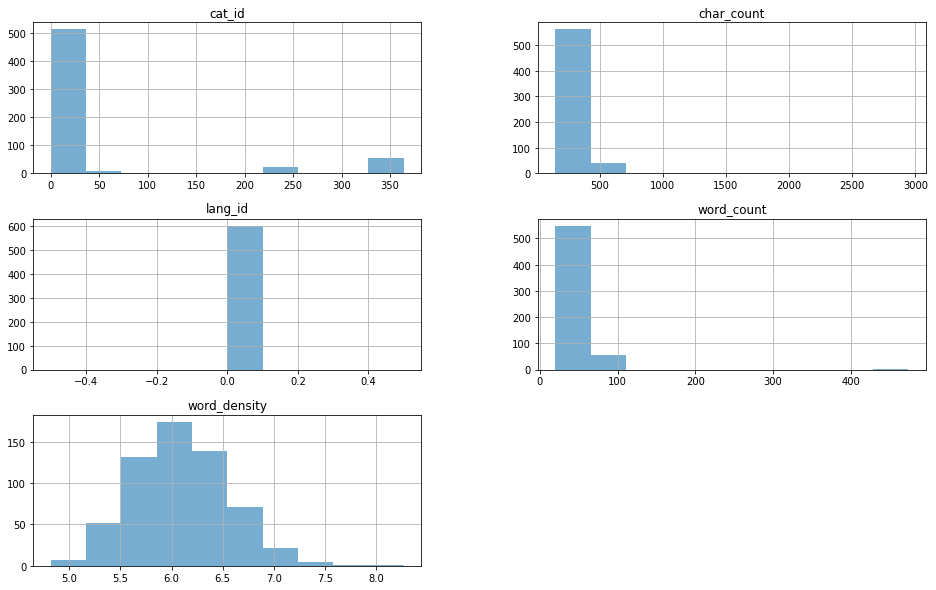

In [10]:
df.hist(figsize=(16,10), grid=True, linewidth=.9, alpha=0.6)
plt.legend(loc=1)
plt.show()

/opt/conda/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/opt/conda/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


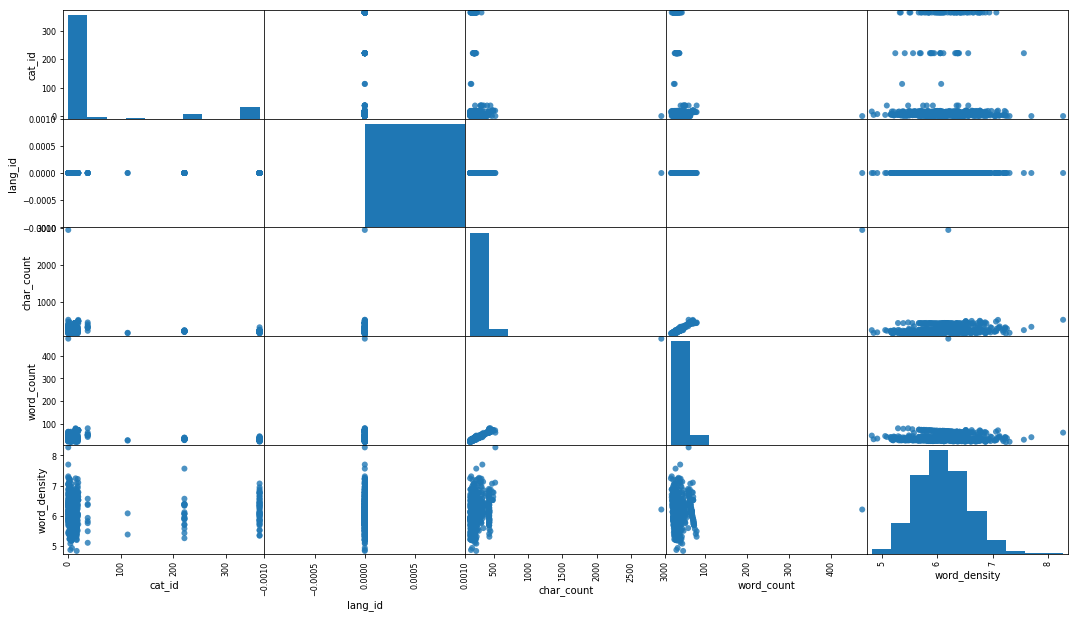

In [11]:
# sns.set()
# sns.pairplot(df, size=3.5)
pd.plotting.scatter_matrix(df, figsize=(18,10), alpha=.8, grid=True, marker='o')
plt.show()

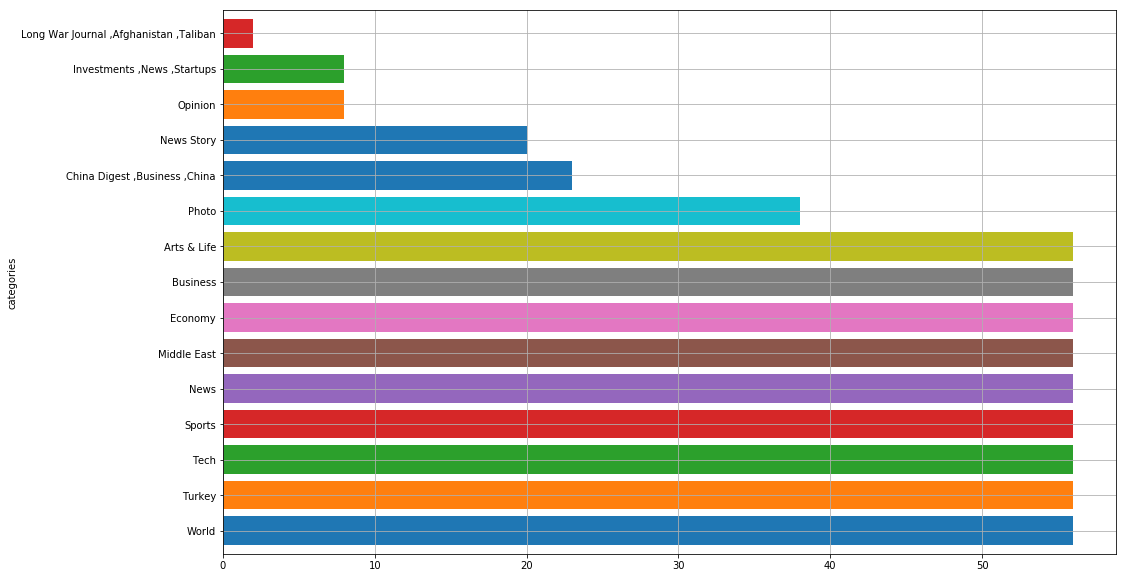

In [12]:
df.groupby('categories').body.count().sort_values(ascending=False).head(65).plot.barh(ylim=0, figsize=(16,10), width=.8, grid=True)
plt.show()

In [13]:
df.head(5)

,body,subject,language,categories,cat_id,lang_id,char_count,word_count,word_density
11,[Nairobi News] Kenya Power has procured and fi...,Kenya:Revealed - Why Your Kenya Power Bills Ar...,English,News,0,0,219,31,6.843750
12,[Govt of SA] The South African Reserve Bank (S...,South Africa:South African Reserve Bank Launch...,English,News,0,0,339,54,6.163636
13,The young footballers and coach of the Moo Pa ...,Thailand: New video shows trapped football tea...,English,News,0,0,162,29,5.400000
14,"Julia Conley, staff writer As Americans a...",'I Can't Afford That': Trapped and Injured in ...,English,News,0,0,376,58,6.372881
15,"Julia Conley, staff writer As Americans a...",'I Can't Afford That': Trapped and Injured by ...,English,News,0,0,376,58,6.372881


In [14]:
# cat_id_df = df[['categories', 'cat_id']].drop_duplicates().sort_values('cat_id')
# cat_to_id = dict(cat_id_df.values)
# id_to_cat = dict(cat_id_df[['cat_id', 'categories']].values)

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', analyzer='word', ngram_range=(1, 2), max_features=5000)
features = tfidf.fit_transform(df.body).toarray()
labels = df.cat_id
print(len(features), len(labels), len(df.index))

(603, 603, 603)


In [16]:
# xtrain, xtest, ytrain, ytest, itrain, itest = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
xtrain, xtest, ytrain, ytest = train_test_split(df['body'], df['categories'], test_size=0.33, random_state=42)

engines = [
    ('RFC', RandomForestClassifier()),
    ('GBC', GradientBoostingClassifier()),
    ('PAC', PassiveAggressiveClassifier()),
    ('RC', RidgeClassifier()),
    ('RCCV', RidgeClassifierCV()),
    ('ETC', ExtraTreesClassifier()),
    ('KNC', KNeighborsClassifier(n_neighbors=10)),
    ('MNB', MultinomialNB())
]
engines_dt = []
today = datetime.date.today()
for name, engine in engines:
    model = make_pipeline(tfidf, engine)
    model.fit(xtrain, ytrain)
    prediction  = model.predict(xtest)
    score = model.score(xtest, prediction)
    # print("{}: Score: {} Accuracy: {:.2f}".format(name, score, accuracy_score(ytest, prediction)))
    engines_dt.append([name, score, accuracy_score(ytest, prediction), today])
    
with open('./data/lsvc.pickle', 'wb') as f:
    joblib.dump(model, f)

/opt/conda/envs/py2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [17]:
df_dt = pd.DataFrame(engines_dt, columns=['engine', 'score', 'accuracy', 'date'])
df_dt

,engine,score,accuracy,date
0,RFC,1.0,0.517588,2018-11-23
1,GBC,1.0,0.502513,2018-11-23
2,PAC,1.0,0.557789,2018-11-23
3,RC,1.0,0.623116,2018-11-23
4,RCCV,1.0,0.608040,2018-11-23
5,ETC,1.0,0.497487,2018-11-23
6,KNC,1.0,0.512563,2018-11-23
7,MNB,1.0,0.557789,2018-11-23


In [18]:
print(classification_report(ytest, prediction))

                                        precision    recall  f1-score   support

                           Arts & Life       0.36      0.71      0.48        17
                              Business       0.75      0.55      0.63        22
         China Digest ,Business ,China       1.00      1.00      1.00         8
                               Economy       0.43      0.53      0.48        19
           Investments ,News ,Startups       1.00      0.50      0.67         2
Long War Journal ,Afghanistan ,Taliban       0.00      0.00      0.00         1
                           Middle East       0.85      0.74      0.79        23
                                  News       0.38      0.29      0.33        17
                            News Story       0.00      0.00      0.00         6
                               Opinion       0.00      0.00      0.00         3
                                 Photo       0.90      0.90      0.90        10
                                Sports 

/opt/conda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
s = '''

Now 86, Foreman was acquitted of two 1960s murders, those of Tommy “Ginger” Marks and Frank “the Mad Axeman” Mitchell, both of which he later admitted in his autobiography, Respect, when it was published in 1997. In those days, the double jeopardy rule meant that you could not be tried twice for the same crime, but the law changed with the 2003 Criminal Justice Act so that “new and compelling” evidence can lead to a retrial.

Marks had been involved in an attack on Foreman’s philandering brother, George, who was shot in the groin for having an affair with a local villain’s wife. Foreman is a little coy on the subject when pressed on film about all this by its director, Paul Van Carter. “I’m not happy about this, Paul,” he says at one stage as he revisits the scene in Bethnal Green where Marks was shot dead in 1965 and is asked to describe what happened. “I don’t know. I wasn’t there.”

He is equally tightlipped about Mitchell, whom the Krays had helped escape from Dartmoor prison and hidden in London, but who had become a loose cannon; according to Foreman today, Mitchell had been armed and vowed to take six policemen with him rather than return to jail. The Krays he now describes as “bad news” – and the film makes it clear what a grim and brutal crew they were.

He is also reticent about his undertaking skills in disposing of McVitie, for which he was jailed for 10 years in 1969. “There was a facility to go out to sea,” he says in the film. “Let’s just leave it at that.” That facility was for a body to be wrapped in chicken wire, attached to weights and dumped in “muddy waters”.

Gang warfare in its current form has claimed many lives already this year, with dozens of fatal stabbings in London, many of them gang-related and involving much younger men than in the 1960s mayhem. How do the two worlds compare? “I think it’s terrible what’s going on,” he says. “ I have no respect for anyone just stabbing someone with a 12-inch blade – a child can stab another person. You don’t prove you’re a hard man by stabbing someone. Years ago, when you had an argument, it was a matter of a straightener – a street fight, bare-knuckle. This showed how tough you were.”

Would any of today’s young post-code gang members, who also seek that word “respect” by stabbing each other, be writing their memoirs or appearing on film in half a century? “I don’t think anyone who has turned to crime these days is going to live long enough to build up a reputation, are they? It’s impossible to get away with it now, with all the CCTV and everything.”

Advertisement

Born in 1932, the son of a respectable taxi driver and the youngest of five brothers, the elder of whom served in the second world war, Foreman was initially evacuated but returned during the blitz and witnessed some of its effects, which, he says, still give him nightmares. His own teenage years involved different forms of violence to the knife-wielders and moped robbers of today.

“I was at the Old Bailey at 16 years of age for affray. One of the weapons produced in evidence was a sand-weighted sock.” He laughs at the memory. “But I don’t want to glamourise what I did because it’s not fucking glamorous, is it? I’ve done 16 years inside, so when you weigh up the pros and cons of it I don’t see it balancing out in my favour. All the money I got out of crime, it doesn’t pay off in the long term. The lessons speak for themselves: missing all your birthdays and Christmases and new years, missing out on your children growing up.” He says he sees little of his own family now.

So what about those old crimes he has written about in the past? “I don’t want to glorify anything,” he says of the murders. “They’ve got relatives and I don’t want to keep rubbing it in. I knew Jack the Hat’s boys when I was living in Spain and we were quite pals together; they used to have a drink with me in Eagles, the country club I had there.”

But in the film he describes in some detail shooting, not fatally, two men who had assaulted a young woman in one of his clubs. (He had an extensive property portfolio before the law caught up with him, which included clubs, pubs, flats, a casino, a recording studio and a boxing gym.) “Blew his ear off,” he says of one of the miscreants. “That was the end of that little scenario.”

The foreword to The Last Real Gangster, published in 2015, was written by the actor Tom Hardy, who consulted Foreman as he prepared to play both Kray twins in Legend, the Brian Helgeland film that broke box office records that year. What did he think of the film? “Not much – but Tom Hardy was amazing. There’s only been one film (of that genre) I really liked and that was The Long Good Friday. Everyone says it was based on me – there were so many similarities.”

His other long jail sentence, of nine years, was for involvement in the £6m Security Express robbery in Shoreditch, east London, in 1983. Foreman was arrested years later for handling the proceeds of the robbery after he had moved to the Costa del Crime in Spain, bought property and opened his club. Much to his indignation, as there was then no extradition treaty between Spain and the UK, he was hoisted back to England still in his shorts and flip-flops. The robbery’s ringleader was Terry Perkins who died, aged 69, earlier this year in Belmarsh jail, having been convicted of the 2015 £14m Hatton Garden safe deposit burglary. Would he have gone with Perkins on that “one last job” if he had been asked? “I’m retired! Can’t do it any more.”

How did the film, which has the song “Oh, sinner man, where you gonna run to?” over its end titles, come about? Was it his idea? “Nothing was my idea – I was manipulated right, left and centre,” he says cheerfully, adding that he is happy with the end result and then, diplomatically: “I just hope it encourages kids to get a good education.”
'''

In [20]:
prediction = model.predict([s])
score = model.score([s], prediction)
result = {
    "category": ["{s}: {v}".format(v=x.strip(), s=accuracy_score([x.strip()], prediction)) for x in prediction[0].split(',')],
    "score": str(score)
}
print(dumps(result))

{"category": ["1.0: Tech"], "score": "1.0"}
